In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
dir_name = '/kaggle/input/oil-gas-predict/oil_gas_train'
companies = []

for dirname, _, filenames in os.walk(dir_name):
    for filename in filenames:
        if filename != 'Книга8.xlsx':
            companies.append(filename.replace('.xlsx', ''))

companies.sort()
print(companies)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

['AMPY', 'APA', 'AR', 'BATL', 'BCEI', 'BRY', 'BSM', 'CDEV', 'CHK', 'CLR', 'CNX', 'COG', 'COP', 'CPE', 'CRBO', 'CRC', 'CRK', 'DEN', 'DVN', 'EGY', 'EOG', 'EQT', 'ESTE', 'FANG', 'GDP', 'HES', 'LONE', 'LPI', 'MCF', 'MGY', 'MNRL', 'MRO', 'MTDR', 'MUR', 'NOG', 'OAS', 'OVV', 'PDCE', 'PVAC', 'PXD', 'REI', 'RRC', 'SBOW', 'SD', 'SM', 'SWN', 'TALO', 'TPL', 'VNOM', 'WLL', 'WTI', 'XEC', 'XOG']


Функция mapper преобразует имя компании в датафрейм, прочитанный из excel, так, чтобы данные начинались с Q1 '11 A. (У компании CRBO данные начинаются с Q1 '10 A).
В skiprows отбрасываем первые пустые строки и последние строки, начиная с Valuation.

In [2]:
def mapper(comp_name):
    if comp_name != 'CRBO':
        return pd.read_excel(dir_name + '/' + comp_name + '.xlsx', 
                             skiprows= lambda x: x < 27 or x >= 362, usecols='I:AU')
    else:
        return pd.read_excel(dir_name + '/' + comp_name + '.xlsx', 
                             skiprows= lambda x: x < 27 or x >= 362, usecols='I,N:AY')
dfs = list(map(mapper, companies))

In [3]:
dfs_dict = dict(list(zip(companies, dfs)))

Здесь подправляем съехавшие даты отчетов для компании REI, MCF, ESTE

In [4]:
import datetime
def fix_dates(name, years):
    for year in years:
        for quarter in range(1, 5):
            day = 31 if quarter in [1, 4] else 30
            dfs_dict[name].iloc[0][f"Q{quarter} '{year} A"] = datetime.datetime(2000+year, 
                                                                                3*quarter, day, 0, 0)

In [5]:
fix_dates('REI', [12, 13])
fix_dates('MCF', [11, 12, 13])
fix_dates('ESTE', [11, 12, 13, 14])

rows_to_exclude - заголовки для строк, в которых находятся только даты, поэтому их удаляем, чтобы не было повторения данных

In [6]:
rows_to_exclude = ['BALANCE SHEET', 'CASH FLOW STATEMENT', 'CHANGES TO SHAREHOLDER EQUITY', 'Ratios']

In [7]:
def clean_data(df):
    # убираем строки без названия
    df1 = df
    df1.dropna(subset=['Unnamed: 8'], inplace=True)
    df1.replace(['#ССЫЛКА!', '#N/A Field Not Applicable', 'n.a.'], np.nan, inplace=True) 
    # убираем заглавные строки для разделов таблицы с датами
    for row in rows_to_exclude:
        df1 = df1.loc[df['Unnamed: 8'] != row]    
    df1.reset_index(inplace=True, drop=True)
    return df1
   

In [8]:
def delete_duplicates(df):
    df1 = df
    seen = set()
    dupes_indices = []

    for i, x in enumerate(list(df1['Unnamed: 8'])):
        if x in seen:
            dupes_indices.append(i)
        else:
            seen.add(x)
            
    df1.drop(dupes_indices, inplace=True)
    df1.reset_index(inplace=True, drop=True)
    return df1

In [9]:
for item in companies:
    dfs_dict[item] = clean_data(dfs_dict[item])
    dfs_dict[item] = delete_duplicates(dfs_dict[item])

Дальше ищем и удаляем строки, которые полностью состоят из нулей или из NaN **ДЛЯ ВСЕХ КОМПАНИЙ**

In [10]:
indices_of_zero_rows = []
for index, row in dfs_dict['AMPY'].iterrows():
    flag = 0
    for item in companies:
        if any([x!=0 and pd.isna(x)!=True for x in list(dfs_dict[item].iloc[index])[1:]]):
            flag = 1
            break
    if flag == 0:
        indices_of_zero_rows.append(index)
        
print(indices_of_zero_rows)    
for item in companies:
    dfs_dict[item].drop(indices_of_zero_rows, inplace=True)
    dfs_dict[item].reset_index(inplace=True, drop=True)

[11, 21, 51, 78, 102, 158, 160, 162, 171, 172, 210, 213, 242]


В этой функции мы транспонируем датафрейм, чтобы объекты (даты) были по строкам, а признаки (показатели) - по столбцам.

In [11]:
def transpose(df, company):
    df1 = df
    df1.rename(columns={'Unnamed: 8': 'Quarter'}, inplace=True)
    df1 = df1.T
    df1.columns = df1.iloc[0]
    df1 = df1[1:]
    df1 = df1.reset_index()
    df1 = df1.rename_axis(None, axis=1)
    df1.rename(columns={'INCOME STATEMENT': 'Date', 'index': 'Quarter'}, inplace=True)
    
    revenue = df1['Revenue']
    op_income = df1['Operating Income']
    quarter = df1['Quarter']
    df1.drop(columns=['Revenue', 'Operating Income', 'Quarter'], inplace=True)
    df1['Revenue'] = revenue
    df1['Operating Income'] = op_income
    df1.insert(1, 'Quarter', list(quarter))
    df1.insert(2, 'Company', [company for i in range(len(df1))])
    df1['Quarter'] = df1['Quarter'].apply(lambda x: x[0:2])
    
    return df1
    

In [12]:
dfs_transposed = [transpose(df, name) for name, df in dfs_dict.items()] 

compound - датафрейм, смердженный из всех датафреймов компаний

In [13]:
compound = pd.concat(dfs_transposed)
compound.sort_values(by=['Date', 'Company'], inplace=True)
compound.set_index(['Date', 'Quarter', 'Company'], inplace=True)

In [ ]:
compound.head(54)

In [ ]:
from matplotlib import pyplot as plt
plt.plot(compound.xs(('Q1', 'AR'), level=('Quarter', 'Company')).index, 
         compound.xs(('Q1', 'AR'), level=('Quarter', 'Company'))['Revenue'], label='Q1')
plt.plot(compound.xs(('Q2', 'AR'), level=('Quarter', 'Company')).index, 
         compound.xs(('Q2', 'AR'), level=('Quarter', 'Company'))['Revenue'], label='Q2')
plt.plot(compound.xs(('Q3', 'AR'), level=('Quarter', 'Company')).index, 
         compound.xs(('Q3', 'AR'), level=('Quarter', 'Company'))['Revenue'], label='Q3')
plt.plot(compound.xs(('Q4', 'AR'), level=('Quarter', 'Company')).index, 
         compound.xs(('Q4', 'AR'), level=('Quarter', 'Company'))['Revenue'], label='Q4')
plt.legend()
plt.show()

In [17]:
compound.xs('AMPY', level='Company')

,,Consensus:,% Surprise | % Est. vs Consensus,Revenue Growth (YoY),Cost of Revenue,Gross Profit,Gross margin,Other Operating Income,Operating Expenses,"Selling, General & Admin",Depreciation & Amortization,...,CAPEX / REVENUE,CAPEX / EBITDA,FCF / DEBT,Gross Leverage (Total Debt / EBITDA),Net Leverage (Net Debt / EBITDA),Total Liabilities / Tangible Assets,Cash + AR / Total Assets,Cash % of Revenue,Revenue,Operating Income
Date,Quarter,,,,,,,,,,,,,,,,,,,,,
2011-03-31,Q1,0,0,NaN,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2011-06-30,Q2,0,0,NaN,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2011-09-30,Q3,0,0,NaN,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2011-12-31,Q4,0,0,NaN,-36.854,25.009,0.404264,0,-57.298,-53.396,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61.863,-32.289
2012-03-31,Q1,0,0,NaN,-34.628,13.782,0.284693,0,-11.44,-6.064,0,...,1.496922,2.386183,-0.162479,2.078175,1.9968,0.610817,0.045053,0.044009,48.41,2.342
2012-06-30,Q2,0,0,NaN,-33.967,15.292,0.310441,0,-11.228,-4.956,0,...,2.26921,3.498998,-0.567779,1.190462,1.098733,0.532201,0.039503,0.053065,49.259,4.064
2012-09-30,Q3,0,0,NaN,-37.426,18.072,0.325633,0,-14.398,-7.948,0,...,1.813218,2.928185,-0.30473,1.597666,1.563142,0.587678,0.032677,0.021738,55.498,3.674
2012-12-31,Q4,0,0,0.452225,-50.763,39.076,0.434956,0,-18.396,-11.573,0,...,5.440098,8.194718,-0.642888,4.439583,4.318818,0.617828,0.034657,0.077685,89.839,20.68
2013-03-31,Q1,0,0,0.779426,-56.101,30.041,0.348738,0,-16.981,-11.026,0,...,1.538599,2.408206,-0.088311,4.400568,4.120853,0.649832,0.05367,0.180328,86.142,13.06


In [39]:
compound = compound.astype(np.float64)

In [33]:
smth = compound.xs('AMPY', level='Company')
smth = smth.reset_index()
smth = smth.drop(columns=['Date', 'Quarter'])

In [40]:
compound.dtypes

Consensus:                             float64
% Surprise | % Est. vs Consensus       float64
Revenue Growth (YoY)                   float64
Cost of Revenue                        float64
Gross Profit                           float64
                                        ...   
Total Liabilities / Tangible Assets    float64
Cash + AR / Total Assets               float64
Cash % of Revenue                      float64
Revenue                                float64
Operating Income                       float64
Length: 260, dtype: object

In [36]:
smth.corr(method='pearson').shape

(0, 0)

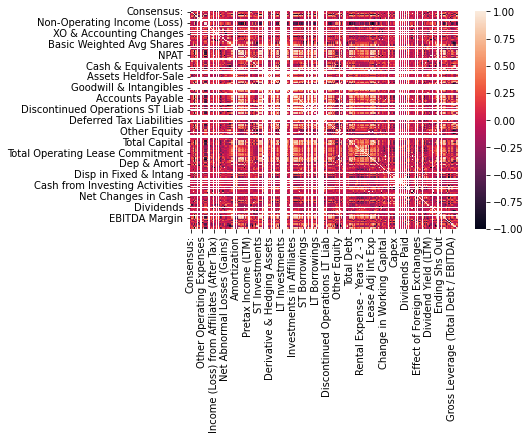

In [42]:
smth = compound.xs('AMPY', level='Company')
sns.heatmap(smth.corr(method='pearson'));
  
plt.show()

In [49]:
cors = smth.corr(method='pearson')
for i in range(cors.shape[1]):
    cors.iloc[i, i] = 0

In [51]:
cors.max()

Consensus:                             0.790552
% Surprise | % Est. vs Consensus       0.717063
Revenue Growth (YoY)                   0.853042
Cost of Revenue                        0.719897
Gross Profit                           0.951606
                                         ...   
Total Liabilities / Tangible Assets    0.832598
Cash + AR / Total Assets               0.963059
Cash % of Revenue                      0.962577
Revenue                                0.951606
Operating Income                       1.000000
Length: 260, dtype: float64

In [52]:
cors[cors.idxmax()]

,Dividends per Share (LTM),ROE,ST Deferred Tax Assets,"Interest Expense, Net",Revenue,Gross Profit,Other Operating Income,Other Operating Expenses,(Inc) Dec in Inventories,Depreciation & Amortization,...,Cash from Financing Activities,CAPEX / REVENUE,Free Cash Flow per Share,Net Leverage (Net Debt / EBITDA),Gross Leverage (Total Debt / EBITDA),Cash + AR / Total Assets,"Cash, Cash Equivalents & STI",Cash + AR / Total Assets,Gross Profit,EBIT
Consensus:,0.790552,-0.410035,-0.155273,0.206271,-0.136276,-0.246414,NaN,0.130959,0.092529,NaN,...,-0.106289,-0.195406,0.165357,0.207894,0.107166,0.122940,0.079073,0.122940,-0.246414,-0.151925
% Surprise | % Est. vs Consensus,-0.779865,0.717063,0.091685,-0.096293,0.172076,0.316099,NaN,-0.063198,-0.054636,NaN,...,0.060708,0.108353,-0.122696,-0.261709,-0.277382,0.151050,0.184290,0.151050,0.316099,0.289742
Revenue Growth (YoY),-0.208156,-0.000396,0.853042,-0.087405,0.503876,0.377123,NaN,-0.280728,-0.121369,NaN,...,0.375343,0.423696,-0.202577,0.228469,0.228588,-0.559762,-0.509115,-0.559762,0.377123,0.181527
Cost of Revenue,0.009973,0.038940,-0.609177,0.719897,-0.968636,-0.845396,NaN,0.166030,-0.091736,NaN,...,-0.222646,-0.134942,0.163579,-0.632808,-0.599256,0.261661,0.036261,0.261661,-0.845396,-0.710086
Gross Profit,-0.332546,0.246603,0.410305,-0.692102,0.951606,0.000000,NaN,-0.359866,0.071388,NaN,...,0.078820,0.017887,-0.043506,0.232800,0.209597,-0.114067,0.036207,-0.114067,0.000000,0.824762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Total Liabilities / Tangible Assets,-0.053421,0.010031,-0.063750,-0.462275,0.072147,0.056213,NaN,0.195523,0.104687,NaN,...,0.121489,-0.034450,-0.293879,0.695361,0.403204,0.832598,0.800526,0.832598,0.056213,0.197184
Cash + AR / Total Assets,-0.173400,0.174485,-0.243673,-0.194779,-0.203230,-0.114067,NaN,0.115771,0.215002,NaN,...,-0.041512,-0.190896,-0.045801,0.197594,0.050801,0.000000,0.963059,0.000000,-0.114067,0.011999
Cash % of Revenue,-0.216393,0.153369,-0.214158,-0.049476,-0.273258,-0.166820,NaN,0.135880,0.151070,NaN,...,-0.012942,-0.135119,0.003972,0.037974,-0.054615,0.962577,0.954843,0.962577,-0.166820,-0.031488
Revenue,-0.160439,0.092316,0.541369,-0.736165,0.000000,0.951606,NaN,-0.262936,0.085991,NaN,...,0.164768,0.084744,-0.113424,0.467909,0.440129,-0.203230,-0.004020,-0.203230,0.951606,0.792233
